## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# ref: Day86
import pandas as pd

# params = {'k1': k1_values, 'k2': k2_values, ...}
# list multi-dimension parameter comnbinations
def to_params_dataframe_list(params):
    df_list = []
    for (i, (key, values)) in enumerate(params.items()):
        if len(values) == 0:
            raise ValueError('not support empty collection')
        if type(values[0]) == dict:
            df_list.append(pd.DataFrame(conv_LD_to_DL(values)))
        else:
            df_list.append(pd.DataFrame({key: values}))
    
    return df_combinations(df_list)    
    
def df_combinations(df_list):
    df_merged = df_list[0].copy()
    for df in df_list[1:]:
        df_merged = df_merged.assign(tmp_key=1).merge(df.assign(tmp_key=1)).drop('tmp_key', 1)
    return df_merged

# in : [{k1:v11, k2:v12, ...}, {k1:v21, k2:v22, ...} ...]
# out: {k1: [v11, v12, ... (sorted unique values)], k2: [v21, v22, ...]}
def unique_by_keys(dicts_list):
    tmp_d = dict()
    for (i, dicts) in enumerate(dicts_list):
        keys = tmp_d.keys()
        for k in dicts.keys():
            if k not in keys:
                tmp_d[k] = set()
        for (k, v) in dicts.items():
            v_set = tmp_d[k]
            v_set.add(v)
    d = {}
    for k, v in tmp_d.items():
        d[k] = sorted(list(v))
        
    return d

# ref: https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
# DL: dict of lists {k1:[v11, v12, ...], k2:[v21, v22, ...]}
# LD: list of dicts [{k1:v11, k2:v12, ...}, {k1:v21, k2:v22, ...}]
def conv_LD_to_DL(LD):
    return {k: [dic[k] for dic in LD] for k in LD[0]}
def conv_DL_to_LD(DL):
    return [dict(zip(DL,t)) for t in zip(*DL.values())]
    

In [3]:
# ref: Day86
import numpy as np
def to_int(bool_val):
    return int(bool_val == 'true')

def to_val(val):
    if type(val) == np.bool_:
        return str(val.astype(int))
    elif type(val) == bool:
        return str(to_int(val))
    else:
        return str(val)

def to_rowkey(cols=[]):
    cols = cols
    def inner(row):
        s = ' '.join([f'{col}:{to_val(row[col])}' for col in cols])
        return f"{s}"
    return inner

def to_plot_legend(cols=[], cols_abbr={}):
    cols = cols
    cols_abbr = dict(zip(cols, cols)) if not cols_abbr else cols_abbr
    def inner(row):
        s = '_'.join([f'{cols_abbr[col]}:{to_val(row[col])}' for col in cols])
        return f'{s}'
    return inner

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1))(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
def gen_optimizer(op_name):
    if op_name == 'adam':
        return keras.optimizers.Adam(lr=LEARNING_RATE)
    elif op_name == 'rmsprop':
        return keras.optimizers.RMSprop(lr=LEARNING_RATE)
    else:
        return keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)

In [10]:
KEY_REDUCE_LR      = "reduce_lr"
KEY_RELR_FACTOR    = 'relr_factor'
KEY_RELR_MIN_LR    = 'relr_min_lr'
KEY_RELR_PATIENCE  = 'relr_patience'
KEY_OPTIMIZER      = 'optimizer'

KEY_EXT_PLOT_LEGEND = '$plot_legend$'
KEY_EXT_ROWKEY      = '$rowkey$'

FACTOR    = KEY_RELR_FACTOR
MIN_LR    = KEY_RELR_MIN_LR
PATIENCE  = KEY_RELR_PATIENCE
## 測試參數設定
opts_optimizer = ['sgd', 'adam', 'rmsprop']
opts_reduce_lr = [
    { FACTOR: 0.1, MIN_LR:1e-12,  PATIENCE:5 },  
    { FACTOR: 0.1, MIN_LR:1e-12,  PATIENCE:10 },  
    { FACTOR: 0.1, MIN_LR:1e-12,  PATIENCE:20 },  
    { FACTOR: 0.5, MIN_LR:1e-12,  PATIENCE:5 },  
    { FACTOR: 0.5, MIN_LR:1e-12,  PATIENCE:10 },  
    { FACTOR: 0.5, MIN_LR:1e-12,  PATIENCE:20 },  
    { FACTOR: 0.9, MIN_LR:1e-12,  PATIENCE:5 },  
    { FACTOR: 0.9, MIN_LR:1e-12,  PATIENCE:10 },  
    { FACTOR: 0.9, MIN_LR:1e-12,  PATIENCE:20 },  
    { FACTOR: 0.5, MIN_LR:1e-6,   PATIENCE:5 },  
    { FACTOR: 0.5, MIN_LR:1e-6,   PATIENCE:10 },  
    { FACTOR: 0.5, MIN_LR:1e-6,   PATIENCE:20 },  
]

uniq_dict = unique_by_keys(opts_reduce_lr)

# ReduceLROnPlateau
# reduce_lr 的 patience 和 factor 
opts_relr_factor    = uniq_dict[FACTOR]
opts_relr_min_lr    = uniq_dict[MIN_LR]
opts_relr_patience  = uniq_dict[PATIENCE]

param_opts = {
    KEY_REDUCE_LR    : opts_reduce_lr,
    #KEY_RELR_FACTOR  : opts_relr_factor,
    #KEY_RELR_MIN_LR  : opts_relr_min_lr,
    #KEY_RELR_PATIENCE: opts_relr_patience,
    KEY_OPTIMIZER    : opts_optimizer,
}

opts_abbr = {
    #KEY_REDUCE_LR     : 'relr',
    KEY_RELR_FACTOR   : 'fa',
    KEY_RELR_MIN_LR   : 'mi',
    KEY_RELR_PATIENCE : 'pa',
    KEY_OPTIMIZER     : 'op',
}
print(f"\ntest parameters:\n{'- '*30}\n{param_opts}")
 
df_opts = to_params_dataframe_list(param_opts)

print(f"\ntest runs: {len(df_opts)}\n{'=-'*30}\n{df_opts}")

# 新增欄位
#raw_cols=[x for x in param_opts.keys()]
raw_cols=[col for col in df_opts.columns.values]
#df_opts[KEY_EXT_ROWKEY]      = df_opts[raw_cols].apply(to_rowkey(raw_cols), axis=1)
df_opts[KEY_EXT_PLOT_LEGEND] = df_opts[raw_cols].apply(to_plot_legend(raw_cols, opts_abbr), axis=1)

print(f"\ndf_opts:\n{'=-'*30}\n{df_opts}")


test parameters:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
{'reduce_lr': [{'relr_factor': 0.1, 'relr_min_lr': 1e-12, 'relr_patience': 5}, {'relr_factor': 0.1, 'relr_min_lr': 1e-12, 'relr_patience': 10}, {'relr_factor': 0.1, 'relr_min_lr': 1e-12, 'relr_patience': 20}, {'relr_factor': 0.5, 'relr_min_lr': 1e-12, 'relr_patience': 5}, {'relr_factor': 0.5, 'relr_min_lr': 1e-12, 'relr_patience': 10}, {'relr_factor': 0.5, 'relr_min_lr': 1e-12, 'relr_patience': 20}, {'relr_factor': 0.9, 'relr_min_lr': 1e-12, 'relr_patience': 5}, {'relr_factor': 0.9, 'relr_min_lr': 1e-12, 'relr_patience': 10}, {'relr_factor': 0.9, 'relr_min_lr': 1e-12, 'relr_patience': 20}, {'relr_factor': 0.5, 'relr_min_lr': 1e-06, 'relr_patience': 5}, {'relr_factor': 0.5, 'relr_min_lr': 1e-06, 'relr_patience': 10}, {'relr_factor': 0.5, 'relr_min_lr': 1e-06, 'relr_patience': 20}], 'optimizer': ['sgd', 'adam', 'rmsprop']}

test runs: 36
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    relr_fac

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

results = {}

test_runs = df_opts.shape[0]
for idx, opts in df_opts.iterrows():
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    p_relr_factor   = opts[KEY_RELR_FACTOR]
    p_relr_min_lr   = opts[KEY_RELR_MIN_LR]
    p_relr_patience = opts[KEY_RELR_PATIENCE]
    p_optimizer     = opts[KEY_OPTIMIZER]

    reduce_lr = ReduceLROnPlateau(factor=p_relr_factor, 
                                  min_lr=p_relr_min_lr, 
                                  monitor='val_loss', 
                                  patience=p_relr_patience, 
                                  verbose=1)

    model = build_mlp(input_shape=x_train.shape[1:])

    print()
    print('-'*60)
    print(f"Experiment with {idx+1}/{test_runs}: \n{opts}")
    print()
    print(model.summary())

    optimizer = gen_optimizer(p_optimizer)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = opts[KEY_EXT_PLOT_LEGEND]
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'params': opts
                            }        

Instructions for updating:
Colocations handled automatically by placer.

------------------------------------------------------------
Experiment with 1/36: 
relr_factor                              0.1
relr_min_lr                            1e-12
relr_patience                              5
optimizer                                sgd
$plot_legend$    fa:0.1_mi:1e-12_pa:5_op:sgd
Name: 0, dtype: object

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    


50000/50000 [==============================] - 9s 180us/step - loss: 0.9095 - acc: 0.6992 - val_loss: 1.4372 - val_acc: 0.5039
Epoch 42/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.9091 - acc: 0.7014 - val_loss: 1.4372 - val_acc: 0.5041

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 43/50
50000/50000 [==============================] - 9s 180us/step - loss: 0.9094 - acc: 0.7006 - val_loss: 1.4372 - val_acc: 0.5041
Epoch 44/50
50000/50000 [==============================] - 9s 178us/step - loss: 0.9090 - acc: 0.7009 - val_loss: 1.4372 - val_acc: 0.5039
Epoch 45/50
50000/50000 [==============================] - 9s 178us/step - loss: 0.9091 - acc: 0.7013 - val_loss: 1.4372 - val_acc: 0.5040
Epoch 46/50
50000/50000 [==============================] - 9s 179us/step - loss: 0.9089 - acc: 0.7013 - val_loss: 1.4373 - val_acc: 0.5037
Epoch 47/50
50000/50000 [==============================] - 9s 179us/step - loss: 0.9085 - acc: 0

50000/50000 [==============================] - 9s 185us/step - loss: 0.5869 - acc: 0.8168 - val_loss: 1.3693 - val_acc: 0.5479
Epoch 35/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.5860 - acc: 0.8182 - val_loss: 1.3694 - val_acc: 0.5479
Epoch 36/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.5862 - acc: 0.8168 - val_loss: 1.3695 - val_acc: 0.5478
Epoch 37/50
50000/50000 [==============================] - 9s 188us/step - loss: 0.5871 - acc: 0.8186 - val_loss: 1.3696 - val_acc: 0.5477
Epoch 38/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.5872 - acc: 0.8171 - val_loss: 1.3696 - val_acc: 0.5480

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 39/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.5864 - acc: 0.8175 - val_loss: 1.3696 - val_acc: 0.5481
Epoch 40/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.5866 - acc: 0.

50000/50000 [==============================] - 9s 185us/step - loss: 0.8371 - acc: 0.7211 - val_loss: 1.3112 - val_acc: 0.5434
Epoch 28/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.8362 - acc: 0.7214 - val_loss: 1.3120 - val_acc: 0.5429

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 29/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.8322 - acc: 0.7231 - val_loss: 1.3121 - val_acc: 0.5432
Epoch 30/50
50000/50000 [==============================] - 9s 181us/step - loss: 0.8341 - acc: 0.7221 - val_loss: 1.3124 - val_acc: 0.5439
Epoch 31/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.8331 - acc: 0.7219 - val_loss: 1.3126 - val_acc: 0.5437
Epoch 32/50
50000/50000 [==============================] - 9s 183us/step - loss: 0.8323 - acc: 0.7231 - val_loss: 1.3128 - val_acc: 0.5431
Epoch 33/50
50000/50000 [==============================] - 9s 184us/step - loss: 0.8329 - acc: 0

50000/50000 [==============================] - 9s 175us/step - loss: 1.0524 - acc: 0.6429 - val_loss: 1.4622 - val_acc: 0.4917
Epoch 21/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.0306 - acc: 0.6497 - val_loss: 1.4627 - val_acc: 0.4951
Epoch 22/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.0086 - acc: 0.6600 - val_loss: 1.4750 - val_acc: 0.4899
Epoch 23/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.9886 - acc: 0.6677 - val_loss: 1.4652 - val_acc: 0.4976
Epoch 24/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9661 - acc: 0.6769 - val_loss: 1.4737 - val_acc: 0.5001
Epoch 25/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.9452 - acc: 0.6842 - val_loss: 1.4689 - val_acc: 0.4890
Epoch 26/50
50000/50000 [==============================] - 9s 174us/step - loss: 0.9236 - acc: 0.6924 - val_loss: 1.4599 - val_acc: 0.4926
Epoch 27/50
50000/50000 [=============

50000/50000 [==============================] - 10s 194us/step - loss: 0.8564 - acc: 0.6995 - val_loss: 1.7678 - val_acc: 0.4268
Epoch 15/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.8345 - acc: 0.7055 - val_loss: 2.0053 - val_acc: 0.3852
Epoch 16/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.7884 - acc: 0.7233 - val_loss: 1.7457 - val_acc: 0.4429

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 17/50
50000/50000 [==============================] - 10s 210us/step - loss: 0.6497 - acc: 0.7843 - val_loss: 1.4860 - val_acc: 0.5052
Epoch 18/50
50000/50000 [==============================] - 10s 194us/step - loss: 0.5942 - acc: 0.8093 - val_loss: 1.4114 - val_acc: 0.5293
Epoch 19/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.5723 - acc: 0.8186 - val_loss: 1.3888 - val_acc: 0.5342
Epoch 20/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.5584 -

50000/50000 [==============================] - 11s 225us/step - loss: 1.1610 - acc: 0.5924 - val_loss: 1.9635 - val_acc: 0.3638
Epoch 9/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.1213 - acc: 0.6059 - val_loss: 2.0268 - val_acc: 0.3353
Epoch 10/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.0907 - acc: 0.6149 - val_loss: 1.9901 - val_acc: 0.3590
Epoch 11/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.0534 - acc: 0.6296 - val_loss: 2.0282 - val_acc: 0.3651
Epoch 12/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.0220 - acc: 0.6403 - val_loss: 2.1811 - val_acc: 0.3271
Epoch 13/50
50000/50000 [==============================] - 10s 190us/step - loss: 0.9915 - acc: 0.6504 - val_loss: 1.7034 - val_acc: 0.4235
Epoch 14/50
50000/50000 [==============================] - 11s 220us/step - loss: 0.9555 - acc: 0.6636 - val_loss: 1.9052 - val_acc: 0.4133
Epoch 15/50
50000/50000 [==========

Epoch 2/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.7547 - acc: 0.3890 - val_loss: 1.7993 - val_acc: 0.3692
Epoch 3/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.6289 - acc: 0.4295 - val_loss: 1.6841 - val_acc: 0.4125
Epoch 4/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5566 - acc: 0.4531 - val_loss: 1.6542 - val_acc: 0.4216
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4998 - acc: 0.4740 - val_loss: 1.6194 - val_acc: 0.4349
Epoch 6/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4533 - acc: 0.4930 - val_loss: 1.5820 - val_acc: 0.4428
Epoch 7/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4127 - acc: 0.5078 - val_loss: 1.5520 - val_acc: 0.4594
Epoch 8/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.3781 - acc: 0.5202 - val_loss: 1.5353 - val_acc: 0.4624
Epoch 9/50
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 270us/step - loss: 1.7617 - acc: 0.3879 - val_loss: 1.9850 - val_acc: 0.3349
Epoch 2/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.4856 - acc: 0.4767 - val_loss: 2.1000 - val_acc: 0.3149
Epoch 3/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.3837 - acc: 0.5125 - val_loss: 2.0799 - val_acc: 0.3234
Epoch 4/50
50000/50000 [==============================] - 11s 210us/step - loss: 1.3151 - acc: 0.5372 - val_loss: 1.9575 - val_acc: 0.3379
Epoch 5/50
50000/50000 [==============================] - 10s 202us/step - loss: 1.2522 - acc: 0.5567 - val_loss: 1.8678 - val_acc: 0.3686
Epoch 6/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.1926 - acc: 0.5801 - val_loss: 1.6824 - val_acc: 0.4056
Epoch 7/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.1360 - acc: 0.5999 - val_loss: 1.7

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 220us/step - loss: 1.8136 - acc: 0.3696 - val_loss: 1.8842 - val_acc: 0.3513
Epoch 2/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.5442 - acc: 0.4538 - val_loss: 2.1345 - val_acc: 0.2923
Epoch 3/50
50000/50000 [==============================] - 10s 209us/step - loss: 1.4391 - acc: 0.4891 - val_loss: 2.6013 - val_acc: 0.2838
Epoch 4/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.3631 - acc: 0.5204 - val_loss: 2.3237 - val_acc: 0.3044
Epoch 5/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.3022 - acc: 0.5392 - val_loss: 2.1297 - val_acc: 0.3082
Epoch 6/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.2514 - acc: 0.5567 - val_loss: 2.1843 - val_acc: 0.2925
Epoch 7/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.2114 - acc: 0.5717 - val_loss: 2.02

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 248us/step - loss: 2.1814 - acc: 0.2831 - val_loss: 2.0649 - val_acc: 0.3305
Epoch 2/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.7314 - acc: 0.3970 - val_loss: 1.8246 - val_acc: 0.3809
Epoch 3/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.6066 - acc: 0.4377 - val_loss: 1.7129 - val_acc: 0.4072
Epoch 4/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.5330 - acc: 0.4647 - val_loss: 1.6361 - val_acc: 0.4225
Epoch 5/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4767 - acc: 0.4833 - val_loss: 1.6134 - val_acc: 0.4355
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4317 - acc: 0.5013 - val_loss: 1.5776 - val_acc: 0.4463
Epoch 7/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.3929 - acc: 0.5140 - val_loss: 1.5555 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.7703 - acc: 0.3843 - val_loss: 1.7798 - val_acc: 0.3741
Epoch 2/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.4976 - acc: 0.4734 - val_loss: 1.7750 - val_acc: 0.3665
Epoch 3/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.3992 - acc: 0.5063 - val_loss: 1.8348 - val_acc: 0.3535
Epoch 4/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.3201 - acc: 0.5365 - val_loss: 1.9115 - val_acc: 0.3548
Epoch 5/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.2529 - acc: 0.5607 - val_loss: 1.8995 - val_acc: 0.3673
Epoch 6/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.2043 - acc: 0.5775 - val_loss: 1.8681 - val_acc: 0.3630
Epoch 7/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.1411 - acc: 0.5995 - val_loss: 2.4140

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 1.8304 - acc: 0.3719 - val_loss: 2.3636 - val_acc: 0.2663
Epoch 2/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.5439 - acc: 0.4539 - val_loss: 2.5119 - val_acc: 0.2871
Epoch 3/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.4402 - acc: 0.4912 - val_loss: 1.8032 - val_acc: 0.3728
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.3601 - acc: 0.5213 - val_loss: 1.8868 - val_acc: 0.3712
Epoch 5/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.3061 - acc: 0.5376 - val_loss: 2.1164 - val_acc: 0.3501
Epoch 6/50
50000/50000 [==============================] - 12s 247us/step - loss: 1.2470 - acc: 0.5593 - val_loss: 1.9673 - val_acc: 0.3358
Epoch 7/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.2001 - acc: 0.5776 - val_loss: 1.9

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 227us/step - loss: 2.2102 - acc: 0.2649 - val_loss: 2.0510 - val_acc: 0.3121
Epoch 2/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7405 - acc: 0.3910 - val_loss: 1.8140 - val_acc: 0.3740
Epoch 3/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.6184 - acc: 0.4326 - val_loss: 1.7118 - val_acc: 0.3990
Epoch 4/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5451 - acc: 0.4597 - val_loss: 1.6338 - val_acc: 0.4290
Epoch 5/50
50000/50000 [==============================] - 11s 210us/step - loss: 1.4879 - acc: 0.4811 - val_loss: 1.5961 - val_acc: 0.4403
Epoch 6/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.4432 - acc: 0.4967 - val_loss: 1.5741 - val_acc: 0.4507
Epoch 7/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.4018 - acc: 0.5133 - val_loss: 1.55

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 226us/step - loss: 1.7692 - acc: 0.3855 - val_loss: 1.9605 - val_acc: 0.3506
Epoch 2/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.4904 - acc: 0.4734 - val_loss: 1.7011 - val_acc: 0.3988
Epoch 3/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.3896 - acc: 0.5127 - val_loss: 1.6821 - val_acc: 0.4092
Epoch 4/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.3127 - acc: 0.5410 - val_loss: 1.9358 - val_acc: 0.3744
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.2496 - acc: 0.5614 - val_loss: 1.8392 - val_acc: 0.3742
Epoch 6/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.1884 - acc: 0.5829 - val_loss: 1.9948 - val_acc: 0.3463
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.1391 - acc: 0.6001 - val_loss: 1.9207 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 217us/step - loss: 1.8181 - acc: 0.3706 - val_loss: 2.1683 - val_acc: 0.2879
Epoch 2/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.5435 - acc: 0.4546 - val_loss: 1.8853 - val_acc: 0.3285
Epoch 3/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.4382 - acc: 0.4913 - val_loss: 1.8825 - val_acc: 0.3503
Epoch 4/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3660 - acc: 0.5151 - val_loss: 2.3911 - val_acc: 0.2730
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2957 - acc: 0.5430 - val_loss: 1.9605 - val_acc: 0.3414
Epoch 6/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2421 - acc: 0.5630 - val_loss: 2.1988 - val_acc: 0.3318
Epoch 7/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2000 - acc: 0.5766 - val_loss: 1.9237 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 210us/step - loss: 2.1763 - acc: 0.2747 - val_loss: 2.0877 - val_acc: 0.3208
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7385 - acc: 0.3927 - val_loss: 1.8109 - val_acc: 0.3842
Epoch 3/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.6151 - acc: 0.4331 - val_loss: 1.7055 - val_acc: 0.4115
Epoch 4/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5401 - acc: 0.4604 - val_loss: 1.6282 - val_acc: 0.4323
Epoch 5/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4869 - acc: 0.4800 - val_loss: 1.6016 - val_acc: 0.4352
Epoch 6/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4423 - acc: 0.4966 - val_loss: 1.5739 - val_acc: 0.4448
Epoch 7/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4031 - acc: 0.5103 - val_loss: 1.5454 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.7715 - acc: 0.3861 - val_loss: 1.8236 - val_acc: 0.3670
Epoch 2/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.4927 - acc: 0.4735 - val_loss: 1.7743 - val_acc: 0.3800
Epoch 3/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.4000 - acc: 0.5080 - val_loss: 1.7493 - val_acc: 0.3806
Epoch 4/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3243 - acc: 0.5347 - val_loss: 2.2691 - val_acc: 0.2733
Epoch 5/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2571 - acc: 0.5564 - val_loss: 1.8928 - val_acc: 0.3437
Epoch 6/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1972 - acc: 0.5756 - val_loss: 2.2138 - val_acc: 0.2811
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1551 - acc: 0.5946 - val_loss: 1.6308 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.8071 - acc: 0.3727 - val_loss: 1.8921 - val_acc: 0.3421
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5359 - acc: 0.4593 - val_loss: 2.5292 - val_acc: 0.2604
Epoch 3/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.4324 - acc: 0.4914 - val_loss: 1.9583 - val_acc: 0.3172
Epoch 4/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.3574 - acc: 0.5203 - val_loss: 3.2828 - val_acc: 0.2133
Epoch 5/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.3012 - acc: 0.5400 - val_loss: 1.9262 - val_acc: 0.3704
Epoch 6/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2459 - acc: 0.5607 - val_loss: 2.4546 - val_acc: 0.2972
Epoch 7/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2003 - acc: 0.5767 - val_loss: 2.0268 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.2015 - acc: 0.2700 - val_loss: 2.2192 - val_acc: 0.3224
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7413 - acc: 0.3911 - val_loss: 1.8132 - val_acc: 0.3817
Epoch 3/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.6195 - acc: 0.4350 - val_loss: 1.7028 - val_acc: 0.4153
Epoch 4/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5464 - acc: 0.4591 - val_loss: 1.6413 - val_acc: 0.4254
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4924 - acc: 0.4797 - val_loss: 1.6014 - val_acc: 0.4403
Epoch 6/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4476 - acc: 0.4951 - val_loss: 1.5665 - val_acc: 0.4509
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4068 - acc: 0.5108 - val_loss: 1.5481 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.7623 - acc: 0.3843 - val_loss: 1.7740 - val_acc: 0.3887
Epoch 2/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.4844 - acc: 0.4783 - val_loss: 1.7758 - val_acc: 0.3706
Epoch 3/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3851 - acc: 0.5124 - val_loss: 1.7515 - val_acc: 0.3904
Epoch 4/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3091 - acc: 0.5385 - val_loss: 1.6594 - val_acc: 0.4159
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2403 - acc: 0.5659 - val_loss: 1.6705 - val_acc: 0.4178
Epoch 6/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1888 - acc: 0.5797 - val_loss: 1.8891 - val_acc: 0.3691
Epoch 7/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1416 - acc: 0.5973 - val_loss: 1.8570 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 216us/step - loss: 1.8148 - acc: 0.3696 - val_loss: 2.6354 - val_acc: 0.2574
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5386 - acc: 0.4566 - val_loss: 2.1635 - val_acc: 0.2987
Epoch 3/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4311 - acc: 0.4911 - val_loss: 2.0399 - val_acc: 0.3090
Epoch 4/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3540 - acc: 0.5198 - val_loss: 1.9325 - val_acc: 0.3294
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2933 - acc: 0.5451 - val_loss: 2.1159 - val_acc: 0.3213
Epoch 6/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2417 - acc: 0.5623 - val_loss: 2.1958 - val_acc: 0.3307
Epoch 7/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.1997 - acc: 0.5768 - val_loss: 1.7791 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.1986 - acc: 0.2737 - val_loss: 2.0930 - val_acc: 0.3183
Epoch 2/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.7417 - acc: 0.3931 - val_loss: 1.8069 - val_acc: 0.3809
Epoch 3/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.6182 - acc: 0.4337 - val_loss: 1.7065 - val_acc: 0.3952
Epoch 4/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.5444 - acc: 0.4593 - val_loss: 1.6393 - val_acc: 0.4228
Epoch 5/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4888 - acc: 0.4805 - val_loss: 1.6092 - val_acc: 0.4329
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4427 - acc: 0.4949 - val_loss: 1.5834 - val_acc: 0.4409
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4026 - acc: 0.5115 - val_loss: 1.5462 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.7683 - acc: 0.3846 - val_loss: 1.8431 - val_acc: 0.3727
Epoch 2/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.4924 - acc: 0.4743 - val_loss: 1.6737 - val_acc: 0.3999
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3972 - acc: 0.5104 - val_loss: 1.8260 - val_acc: 0.3542
Epoch 4/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3095 - acc: 0.5384 - val_loss: 2.1287 - val_acc: 0.3309
Epoch 5/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2403 - acc: 0.5624 - val_loss: 1.7507 - val_acc: 0.4131
Epoch 6/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1880 - acc: 0.5821 - val_loss: 2.1320 - val_acc: 0.3417: 1s - loss: 1.1838 - ac
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.1276 - acc: 0.6

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.8174 - acc: 0.3727 - val_loss: 2.4853 - val_acc: 0.2683
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5422 - acc: 0.4553 - val_loss: 2.2953 - val_acc: 0.3003
Epoch 3/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4388 - acc: 0.4921 - val_loss: 2.0133 - val_acc: 0.3256
Epoch 4/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3602 - acc: 0.5224 - val_loss: 2.3470 - val_acc: 0.2750
Epoch 5/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2989 - acc: 0.5438 - val_loss: 2.1117 - val_acc: 0.2991
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.2505 - acc: 0.5584 - val_loss: 2.1077 - val_acc: 0.2980
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.2073 - acc: 0.5758 - val_loss: 1.9471 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 211us/step - loss: 2.2482 - acc: 0.2660 - val_loss: 2.1933 - val_acc: 0.3130
Epoch 2/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.7533 - acc: 0.3893 - val_loss: 1.8233 - val_acc: 0.3789
Epoch 3/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6198 - acc: 0.4327 - val_loss: 1.7120 - val_acc: 0.4002
Epoch 4/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.5445 - acc: 0.4585 - val_loss: 1.6394 - val_acc: 0.4241
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4911 - acc: 0.4802 - val_loss: 1.6221 - val_acc: 0.4348
Epoch 6/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4449 - acc: 0.4969 - val_loss: 1.5766 - val_acc: 0.4438
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4061 - acc: 0.5094 - val_loss: 1.5539 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.7928 - acc: 0.3775 - val_loss: 1.7416 - val_acc: 0.3889
Epoch 2/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.5033 - acc: 0.4699 - val_loss: 1.8022 - val_acc: 0.3481
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.4021 - acc: 0.5066 - val_loss: 1.7559 - val_acc: 0.3945
Epoch 4/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.3290 - acc: 0.5310 - val_loss: 1.6884 - val_acc: 0.4030
Epoch 5/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2646 - acc: 0.5561 - val_loss: 1.9488 - val_acc: 0.3433
Epoch 6/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2095 - acc: 0.5741 - val_loss: 2.0955 - val_acc: 0.3178
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1587 - acc: 0.5930 - val_loss: 1.6823 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.7913 - acc: 0.3780 - val_loss: 2.4344 - val_acc: 0.2913
Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.5282 - acc: 0.4594 - val_loss: 2.0541 - val_acc: 0.3126
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.4273 - acc: 0.4951 - val_loss: 2.3390 - val_acc: 0.2985
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3609 - acc: 0.5217 - val_loss: 2.1079 - val_acc: 0.3006
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.3022 - acc: 0.5396 - val_loss: 1.9442 - val_acc: 0.3265
Epoch 6/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.2495 - acc: 0.5588 - val_loss: 1.9215 - val_acc: 0.3388
Epoch 7/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2074 - acc: 0.5732 - val_loss: 2.4359 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 208us/step - loss: 2.1713 - acc: 0.2759 - val_loss: 2.0121 - val_acc: 0.3284
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7385 - acc: 0.3929 - val_loss: 1.7802 - val_acc: 0.3848
Epoch 3/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6157 - acc: 0.4327 - val_loss: 1.6694 - val_acc: 0.4147
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.5434 - acc: 0.4576 - val_loss: 1.6351 - val_acc: 0.4276
Epoch 5/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4891 - acc: 0.4778 - val_loss: 1.5904 - val_acc: 0.4467
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4432 - acc: 0.4951 - val_loss: 1.5791 - val_acc: 0.4461
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4042 - acc: 0.5092 - val_loss: 1.5438 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.7672 - acc: 0.3901 - val_loss: 1.9215 - val_acc: 0.3379
Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4932 - acc: 0.4750 - val_loss: 1.8064 - val_acc: 0.3956
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3973 - acc: 0.5068 - val_loss: 1.7264 - val_acc: 0.3956
Epoch 4/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3212 - acc: 0.5373 - val_loss: 1.7909 - val_acc: 0.3624
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2529 - acc: 0.5601 - val_loss: 2.1939 - val_acc: 0.3205
Epoch 6/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.2054 - acc: 0.5746 - val_loss: 1.7110 - val_acc: 0.3900
Epoch 7/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1463 - acc: 0.5962 - val_loss: 1.7902 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 214us/step - loss: 1.7988 - acc: 0.3732 - val_loss: 1.9304 - val_acc: 0.3384
Epoch 2/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.5391 - acc: 0.4579 - val_loss: 2.5356 - val_acc: 0.2466
Epoch 3/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4318 - acc: 0.4943 - val_loss: 2.4267 - val_acc: 0.2851
Epoch 4/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3586 - acc: 0.5201 - val_loss: 2.7981 - val_acc: 0.2733
Epoch 5/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.3028 - acc: 0.5416 - val_loss: 2.4206 - val_acc: 0.2660
Epoch 6/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.2465 - acc: 0.5598 - val_loss: 2.1020 - val_acc: 0.3161

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
50000/50000 [================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 209us/step - loss: 2.2031 - acc: 0.2697 - val_loss: 2.0681 - val_acc: 0.3238
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7382 - acc: 0.3898 - val_loss: 1.8112 - val_acc: 0.3767
Epoch 3/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6167 - acc: 0.4326 - val_loss: 1.6911 - val_acc: 0.4068
Epoch 4/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.5463 - acc: 0.4583 - val_loss: 1.6315 - val_acc: 0.4283
Epoch 5/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4921 - acc: 0.4792 - val_loss: 1.6020 - val_acc: 0.4375
Epoch 6/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4475 - acc: 0.4940 - val_loss: 1.5750 - val_acc: 0.4464
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4098 - acc: 0.5107 - val_loss: 1.5597 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.7593 - acc: 0.3894 - val_loss: 1.8806 - val_acc: 0.3615
Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4933 - acc: 0.4734 - val_loss: 1.8443 - val_acc: 0.3709
Epoch 3/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3919 - acc: 0.5100 - val_loss: 1.8402 - val_acc: 0.3453
Epoch 4/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3154 - acc: 0.5344 - val_loss: 2.1094 - val_acc: 0.3205
Epoch 5/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.2502 - acc: 0.5596 - val_loss: 2.2448 - val_acc: 0.2931
Epoch 6/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1956 - acc: 0.5801 - val_loss: 1.8700 - val_acc: 0.3613
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1515 - acc: 0.5923 - val_loss: 2.4839 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.8010 - acc: 0.3738 - val_loss: 2.0461 - val_acc: 0.3302
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5308 - acc: 0.4580 - val_loss: 2.2441 - val_acc: 0.2856
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.4327 - acc: 0.4964 - val_loss: 2.0797 - val_acc: 0.3161
Epoch 4/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.3518 - acc: 0.5236 - val_loss: 2.0632 - val_acc: 0.2963
Epoch 5/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2985 - acc: 0.5412 - val_loss: 2.0884 - val_acc: 0.2882
Epoch 6/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.2477 - acc: 0.5595 - val_loss: 3.2714 - val_acc: 0.2260
Epoch 7/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.1984 - acc: 0.5770 - val_loss: 2.1183 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 212us/step - loss: 2.1898 - acc: 0.2726 - val_loss: 2.0764 - val_acc: 0.3190
Epoch 2/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.7454 - acc: 0.3924 - val_loss: 1.7986 - val_acc: 0.3785
Epoch 3/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.6221 - acc: 0.4348 - val_loss: 1.6961 - val_acc: 0.4049
Epoch 4/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.5498 - acc: 0.4603 - val_loss: 1.6396 - val_acc: 0.4283
Epoch 5/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4941 - acc: 0.4793 - val_loss: 1.6060 - val_acc: 0.4377
Epoch 6/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.4475 - acc: 0.4965 - val_loss: 1.5696 - val_acc: 0.4491
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.4056 - acc: 0.5125 - val_loss: 1.5582 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 222us/step - loss: 1.7745 - acc: 0.3852 - val_loss: 1.7568 - val_acc: 0.3959
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.4953 - acc: 0.4729 - val_loss: 1.8763 - val_acc: 0.3582
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3946 - acc: 0.5066 - val_loss: 1.9202 - val_acc: 0.3417
Epoch 4/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3159 - acc: 0.5369 - val_loss: 1.9793 - val_acc: 0.3221
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2459 - acc: 0.5632 - val_loss: 2.0255 - val_acc: 0.3338
Epoch 6/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1934 - acc: 0.5802 - val_loss: 2.2286 - val_acc: 0.3230
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1441 - acc: 0.5991 - val_loss: 1.8274 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.8172 - acc: 0.3675 - val_loss: 2.3008 - val_acc: 0.3091
Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.5360 - acc: 0.4585 - val_loss: 1.8873 - val_acc: 0.3361
Epoch 3/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.4295 - acc: 0.4957 - val_loss: 2.4978 - val_acc: 0.2561
Epoch 4/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.3555 - acc: 0.5209 - val_loss: 2.1582 - val_acc: 0.3055
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.2905 - acc: 0.5424 - val_loss: 2.0657 - val_acc: 0.3294
Epoch 6/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.2469 - acc: 0.5603 - val_loss: 1.9099 - val_acc: 0.3587
Epoch 7/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1937 - acc: 0.5797 - val_loss: 1.9887 -

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data(results, title=''):
    print(f"code map:{opts_abbr}")
    
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(24, 8)
    #plt.subplots_adjust(bottom=.05, top=.9, hspace=.9)

    fig.suptitle(title)

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax1.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax1.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    ax1.set_title("Loss")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax2.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax2.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    ax2.set_title("Accuracy")
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
   
    plt.show()

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data_2(results, title=''):
    print(f"code map:{opts_abbr}")
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Loss {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    plt.clf()
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Accuracy {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    print('='*80)
    print()

code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


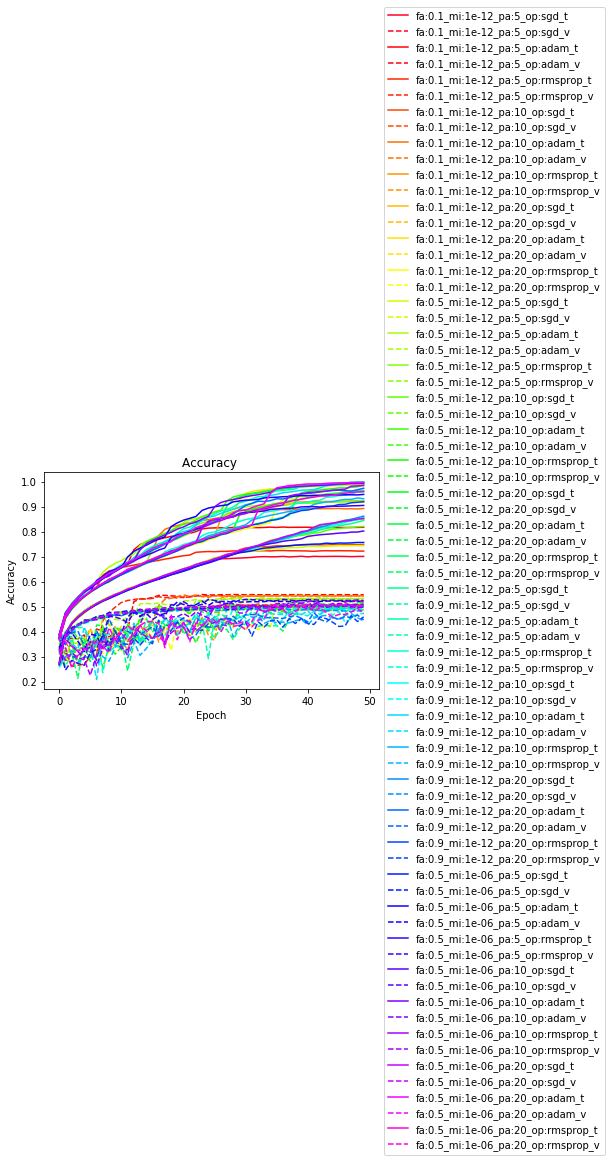

In [14]:
plot_data_2(results)

code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


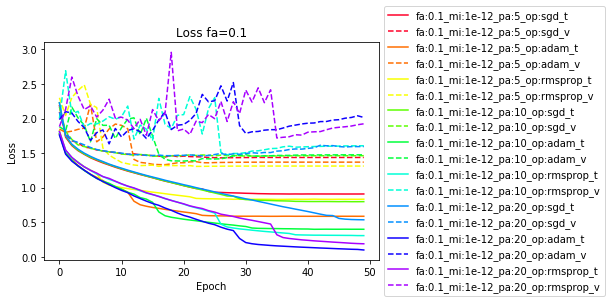

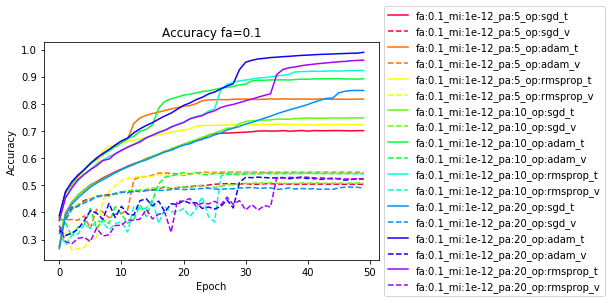


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


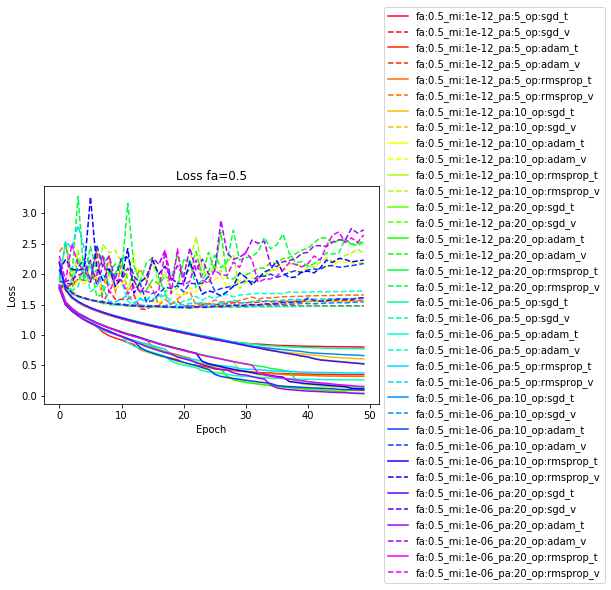

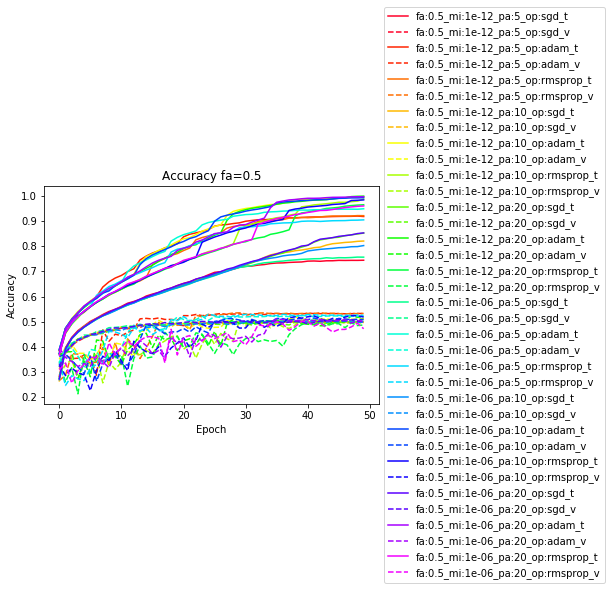


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


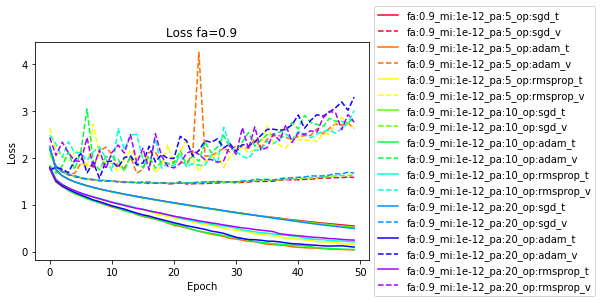

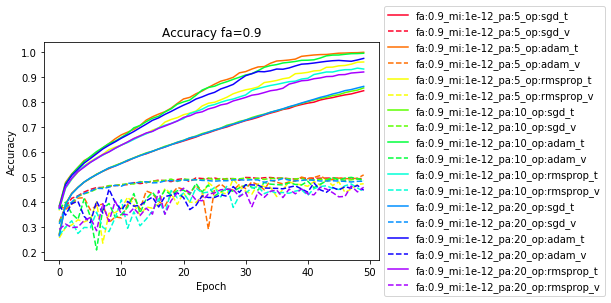

In [15]:
for factor in opts_relr_factor:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_RELR_FACTOR]}:{factor}' in k}
    plot_data_2(results_by_key, title=f'{opts_abbr[KEY_RELR_FACTOR]}={factor}')

code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


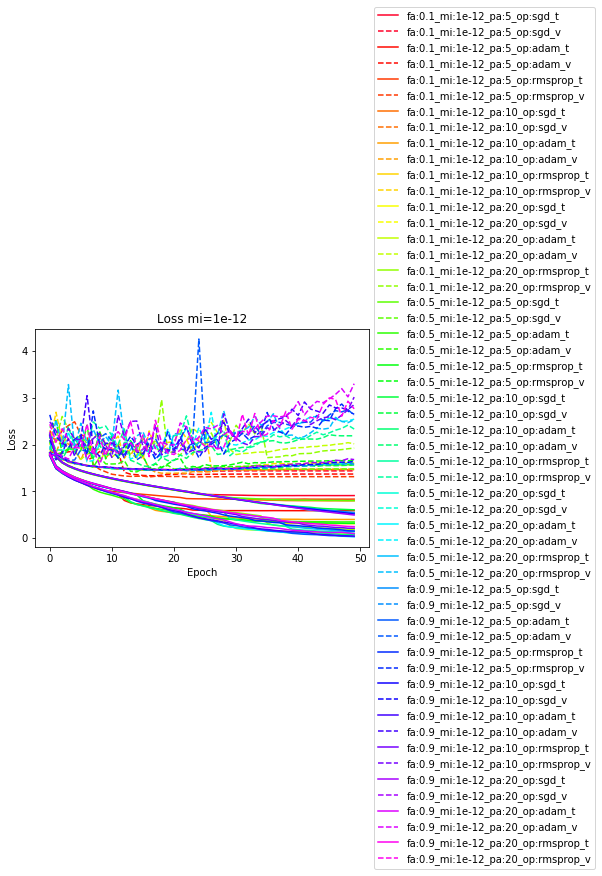

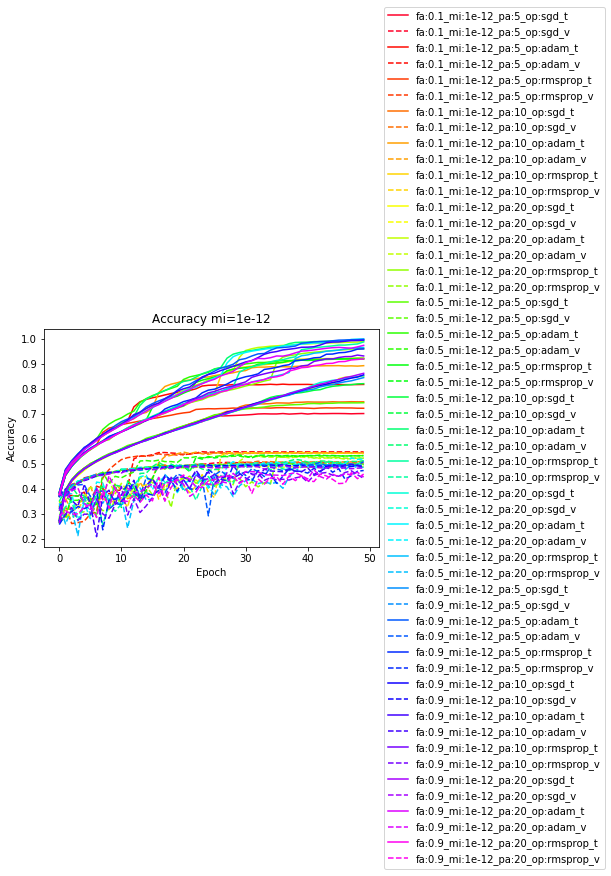


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


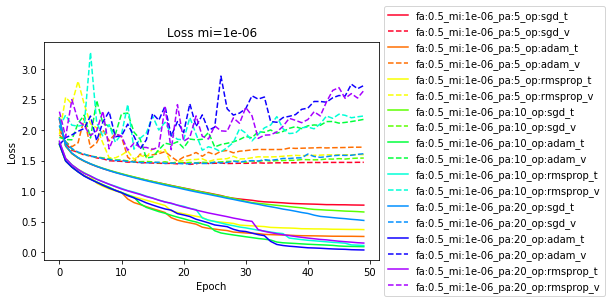

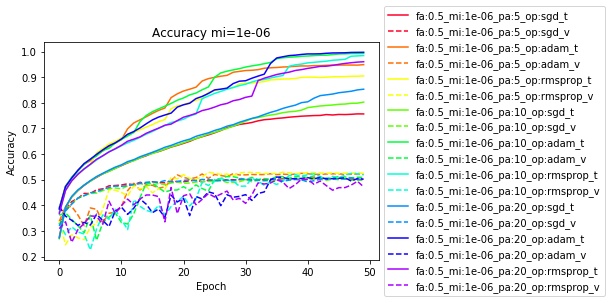

In [16]:
for min_lr in opts_relr_min_lr:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_RELR_MIN_LR]}:{min_lr}' in k}
    plot_data_2(results_by_key, title=f'{opts_abbr[KEY_RELR_MIN_LR]}={min_lr}')

code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


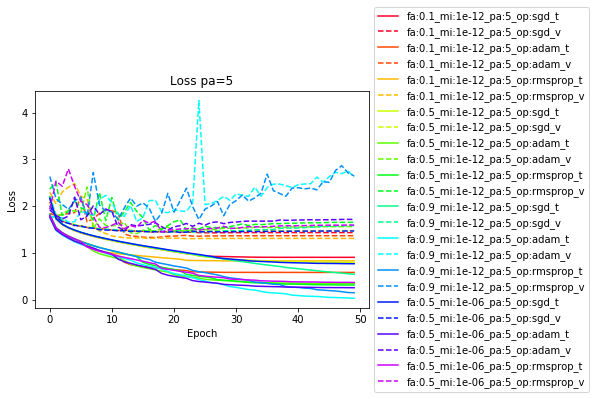

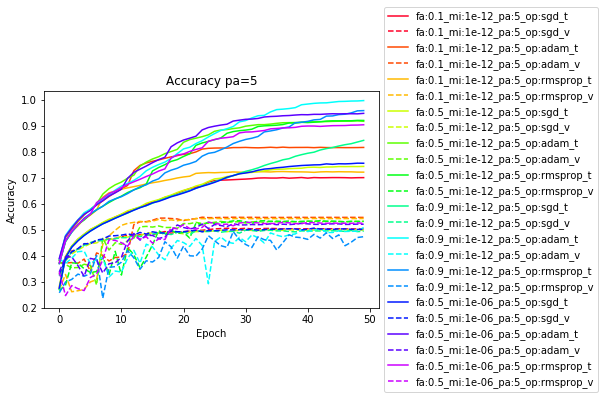


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


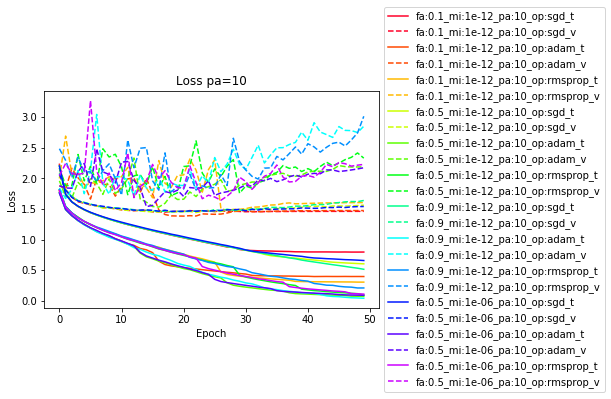

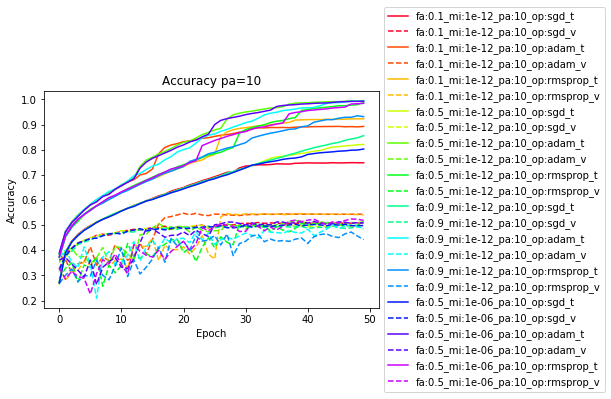


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


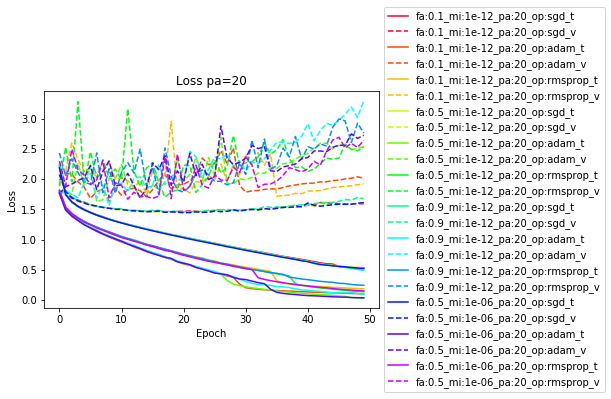

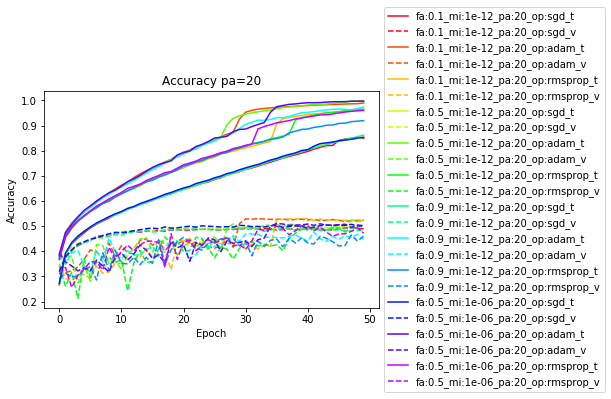

In [17]:
for patience in opts_relr_patience:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_RELR_PATIENCE]}:{patience}' in k}
    plot_data_2(results_by_key, title=f'{opts_abbr[KEY_RELR_PATIENCE]}={patience}')

code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


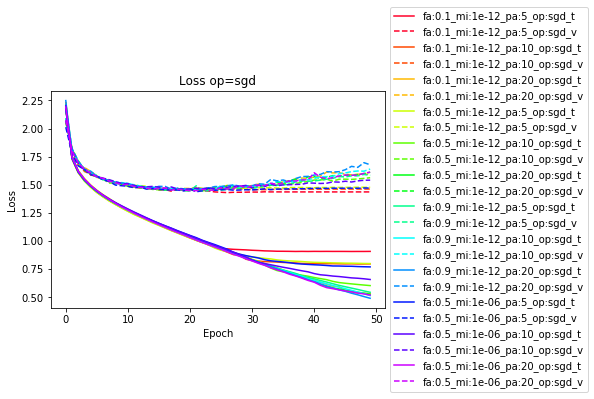

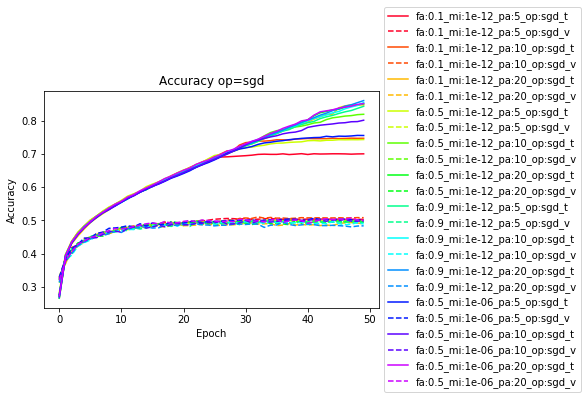


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


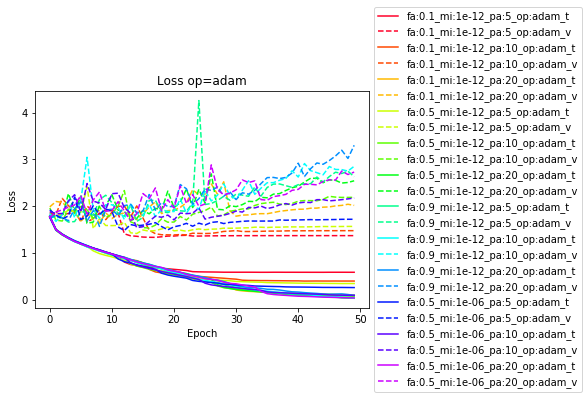

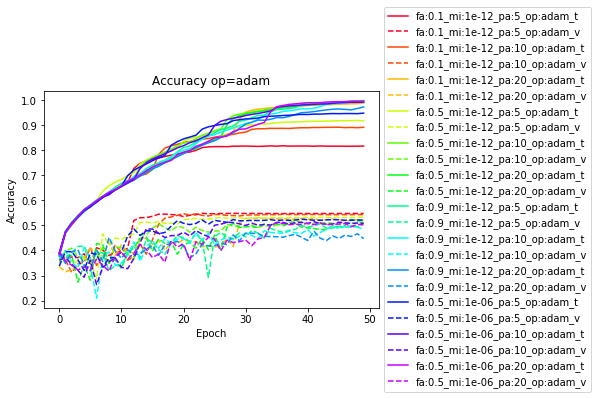


code map:{'relr_factor': 'fa', 'relr_min_lr': 'mi', 'relr_patience': 'pa', 'optimizer': 'op'}


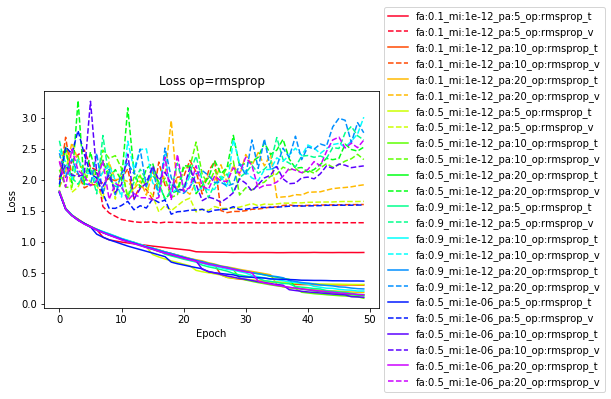

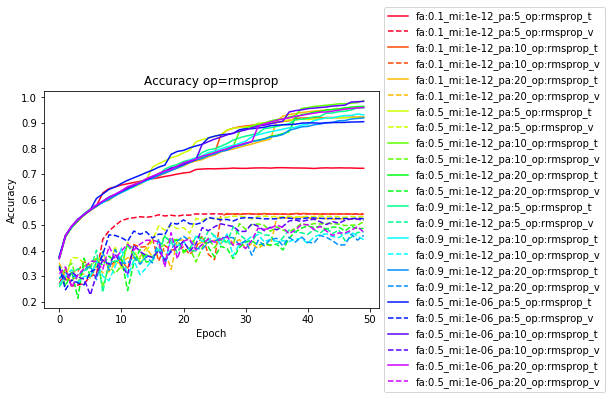

In [18]:
for optimizer in opts_optimizer:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_OPTIMIZER]}:{optimizer}' in k}
    plot_data_2(results_by_key, title=f'{opts_abbr[KEY_OPTIMIZER]}={optimizer}')